# TrpCage protein
- TrpCage is a man-made mini protein (20 residues) that is good for practicing protein folding.  
    - Experimental folding time is shorter than 1 µs.  
- Download the structure file (PDB: 1L2Y): https://www.rcsb.org/structure/1L2Y  
- See the structure using VMD.  
- 1L2Y contains a NMR ensemble of 38 structures.  
    - You can choose any structure as a starting conformation of your MD simulation.  

<img src="../img/trpcage.png" width=150 />

<img src="../img/forcefield.png" width=800 />

### **Processing PDB for Gromacs using `gmx pdb2gmx`**
- We need to process the PDB file downloaded from RCSB such that
    - The atom list matches that in RTP file in the force field ($GMXLIB).   
    - Recover missing atoms (usually hydrogen atoms).  
    - Modifications (e.g., -S-S- disulfide bonds, protonation state, etc.)  
- In Gromacs, we use `gmx pdb2gmx` program  
    - `gmx pdb2gmx -f 1L2Y.pdb -o conf.pdb -ignh`  
        - Select the force field of your choice  
        - Select water model (e.g., TIP3P)  
    - Outputs:  
        - `conf.pdb`: a processed structure file.  
        - `topol.top`: a topology file.  
        - `posre.itp`: position restraints for protein atoms. This is included in `topol.top`.  

<img src="../img/pipeline.png" width=500 />

### **`topol.top`: topology file**
- `topol.top` file contains information on the force field and the simulation system.  
- To see the installed force fields, see $GMXDATA/top directory  
    - `ls $GMXDATA/top`  
- If you chose amber99sb.ff.  
    - `amber99sb.ff/forcefield.itp` contains files with all force field parameters.  
        - See the files that `forcefield.itp` includes.  
    - `amber99sb.ff/tip3p.itp` contains "moleculetype" definition for the TIP3P water model.  
- A reusable part can be saved in a separate file, which can included in `topol.top`   
    - `#include REUSABLE_FILE`  
    - Gromacs simply use the C-preprocessor.  
        - C-preprocessing will simply paste included files in a single long file.  
        - By using `#include`, you can make `topol.top` easy to read.  
- In `topol.top` generated by gmx pdb2gmx, you can find a very long moleculetype definition of TrpCage.  
    - `topol.top` will work fine in this form.  
    - But, you can also save the moleculetype in a separate file, e.g., trpcage.itp, and   
        - `#include "trpcage.itp"`  
        - By doing this, you can reuse the moleculetype for other simulations.  

### **Determine the periodic boundary condition**
- In most MD simulations, we use PBC.  
- Gromacs supports any type of PBC defined by six crystal parameters: a, b, c, alpha, beta, gamma  
- See the first a few lines of `conf.pdb`:  
    ```bash
    TITLE     TC5B
    REMARK    THIS IS A SIMULATION BOX
    CRYST1    1.000    1.000    1.000  90.00  90.00  90.00 P 1           1
    MODEL        1
    ATOM      1  N   ASN A   1      -8.901   4.127  -0.555  1.00  0.00           N
    ATOM      2  H1  ASN A   1      -8.345   3.925   0.252  1.00  0.00            
    ATOM      3  H2  ASN A   1      -8.685   5.045  -0.887  1.00  0.00            
    ```
- CRYST1 defines the lattice parameters.  
    - a=b=c=1 Å  
    - alpha = beta = gamma = 90 degrees.  
    - These parameters define a cubic box of 1 Å edge length.  

<img src="../img/pbc_box.png" width=200 />

- For a near-spherical object such as TrpCage, we can try two lattice types:  
    - Cubic: a=b=c and alpha = beta = gamma = 90  
    - Truncated dodecahedron: a = b = c and alpha = beta = 60, gamma = 90  
- You can edit the PDB file using an editor.  
- For convenience, Gromacs provides a PDB editor program, `gmx editconf`  
    - `gmx editconf -f conf.pdb -o conf.pdb -bt dodecahedron -d 1 -c`  
        - It takes conf.pdb as an input and write conf.pdb as an output.  
        - `-bt`: box type.  
        - `-d`: distance between the protein and the box. Thus, `-d` option will determine the a, b, c paramters.  
        - `-c`: put the protein at the center of the box by translation.  
    - Draw the periodic images in VMD to check if the lattice definition makes sense.  
        - The box must be large enough such that images don't sense one another.  
            - The box must be as small as possible for the simulation speed.  

<img src="../img/pbc_image.png" width=300 />

### **Solvate**
- Once the box is defined, we need to fill the space with water.  
    - `gmx solvate -cp conf.pdb -cs -p topol.top -o conf.pdb`  
        - `-cp`: input PDB file  
        - `-cs`: fill the box with water. By defaults, TIP3P.  
        - `-p`: update `topol.top` file to specify the change.  
            - Last lines of `topol.top` will look like this:  
                ```bash
                [ molecules ]
                ; Compound        #mols
                Protein_chain_A     1
                SOL              2157
                ```
- See the output file in VMD.  
    - Does the water box perfectly fill the space?  

<img src="../img/solvate.png" width=400 />

### **`mdp`: MD Option file**
- MDP file contains MD simulation Options.  
    - See https://manual.gromacs.org/current/user-guide/mdp-options.html for details.  
- Copy a sample MDP file in 1_water_box folder to PWD (present working directory)  
    - `cp files/*.mdp` .  
- Open `grompp.mdp` using a text editor  
    - See each section of the file.  

### **Add ions to the system and Minimize**
- Prepare a `topol.tpr` file for adding ions.  
    TPR file is a binary format file including all information for your MD simulation. This is convenient because you can copy only one TPR file when you want to perform your simulation on another machine.  
    - Gromacs contains a program for adding ions, `gmx genion`.  
    - Inconveniently, `gmx genion` take only TPR file as an input.  
        - Generate a TPR file for `gmx genion`  
        - `gmx grompp -f mini.mdp -c conf.pdb`  
        Now, `gmx genion`
        - `gmx genion -s topol.tpr -neutral -c  onc 0.15 -o conf.pdb -p topol.top`  
            - `-neutral`: make the system charge neutral. It will just add minimum ions for neutralization.  
            - `-conc`: add excess ions to get a desired ion concentration. By default, NaCl.  
            - `-o`: the output PDB file.  
            - `-p`: the output topology file.  
- Now, we're ready to perform MD simulation.  
- Minimize the potential energy of the system.  
    - `gmx grompp -f mini.mdp -c conf.pdb`  
    - `gmx mdrun -nt 4 -gpu_id 0 -c mini.pdb`  
        - `-c`: The minimized system will be written t0 `mini.pdb`  
    - see `md.log` and `ener.edr` files to see change in energy.  
        - `gmx energy -f ener.edr`  

### **MD simulation**
- Open `grompp.mdp` and change the settings:
    ```bash
    nsteps                   = 2500  ; Do MD for 2500 steps  
    nstxout-compressed       = 1     ; write trajectory every step.  
    ```
- Generate `topol.tpr`  
    - `gmx grompp -c mini.pdb -f grompp.mdp`  
        - `-c`: Now, we are using the minimized structure.  
- Perform MD.  
    - `gmx mdrun -nt 4 -gpu_id 0`  
        - it will generate some output files:  
            - `md.log` : text log file  
            - `ener.edr` : binary energy file  
            - `traj_comp.xtc` : trajectory file  
            - `state.cpt` : check point file for continuation  
- See traj_comp.xtc using VMD  
    - In VMD,  
        - Load `mini.pdb`  
        - Then, add `traj_comp.xtc` to` mini.pdb`.  
    - `traj_comp.xtc` will look weird because water molecules at the boundary are broken.  
    - This happens because gmx mdrun wants to have all atoms in a unit cell.  
- We can fix this by using gmx trjconv  
    - Fix `mini.pdb`.  
        - `gmx trjconv -f mini.pdb -pbc mol -ur compact -o mini.pdb`  
    - Fix `traj_comp.xtc`  
        - `gmx trjconv -f traj_comp.xtc -pbc mol -ur compact -o traj_comp_fixed.xtc`  
    - Load `mini.pdb` and `traj_comp_fixed.xtc` VMD, and see the difference.  

### **MD for 1ns**
- Change grompp.mdp:  
    ```bash
    nsteps                   = 5000000  ; 10 ns
    nstxout-compressed       = 10000    ; write trajectory every 20 ps
    ```
- `gmx grompp -c mini.pdb -f grompp.mdp`  
- `gmx mdrun -nt 4 -gpu_id 0 -cpi -noappend`  

#### check box size and temperature  
- `gmx traj -ob -f traj_comp.part0002.xtc`  
    - see `box.xvg`  
- `gmx energy -f ener.part0002.edr`  
    - see `energy.xvg`  

### **Analysis**
- In trpcage folder, you can find 50-µs long trajectories for several different force field.  
    - `native.pdb`:   
    - `all.1ns.xtc`: trajectory file with a time step of 1 ns.  
- Questions  
    - Visually inspect the trajectory files.  
        - Try to make an attractive movie.  
    - Quantify the folding-unfolding behaviors using reasonable order parameters (RMSD, Q, etc.)  
        - What is the free energy difference (∆G) between the folded and unfolded states?  
        - How does ∆G depend on the choice of force field?  
    - Characterize the structural properties such as:  
        - Secondary structures (DSSP or STRIDE programs)  
        - Radial distribution functions.  
        - Ramachandran plots  
        - Hydrogen bonding patterns.  
        - Radius of gyration.  

### **Analysis methods**
- You can perform the analysis by using several different methods:  
    - Gromacs provides many analysis programs that run in a shell.  
        - `gmx traj`  
        - `gmx gyrate`  
        - `gmx rdf`  
        - etc  
    - VMD   
        - GUI  
        - Tcl script  
    - MDTraj  
        - a python library  

In [114]:
import numpy as np
import mdtraj as md
import matplotlib.pyplot as plt
from itertools import combinations
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap

### **Q, RMSD, and Rg**
- Fraction of native contacts:  
- Radius of gyration  
    ```python
    import numpy as np
    import matplotlib
    matplotlib.use('Agg')
    import matplotlib.pyplot as plt

    #######################################
    # Load trajectory
    traj = md.load('all.1ns.xtc', top='native.pdb')
    native = md.load_pdb('native.pdb')
    #######################################

    # Calculate Q, the fraction of native contacts
    # https://mdtraj.org/1.9.4/examples/native-contact.html
    q = best_hummer_q(traj, native)
    plt.plot(q)
    plt.xlabel('Frame', fontsize=14)
    plt.ylabel('Q(X)', fontsize=14)
    plt.show()

    #######################################
    # Radius of gyration
    rg = md.compute_rg(traj)
    plt.plot(rg)
    plt.xlabel('Frame', fontsize=14)
    plt.ylabel('Rg', fontsize=14)
    plt.show()
    ```
- Try to draw 1D free energy landscape using Q or Rg as a reaction coordinate.  
    - First, calculate a 1D histogram, p(x), by binning Q or Rg.  
    - Then, the free energy will be -kT log p(x)  

**Define function of calculating Q and free energy**

In [54]:
def best_hummer_q(traj, native):
    """Compute the fraction of native contacts according the definition from
    Best, Hummer and Eaton [1]
    
    Parameters
    ----------
    traj : md.Trajectory
        The trajectory to do the computation for
    native : md.Trajectory
        The 'native state'. This can be an entire trajecory, or just a single frame.
        Only the first conformation is used
        
    Returns
    -------
    q : np.array, shape=(len(traj),)
        The fraction of native contacts in each frame of `traj`
        
    References
    ----------
    ..[1] Best, Hummer, and Eaton, "Native contacts determine protein folding
          mechanisms in atomistic simulations" PNAS (2013)
    """
    
    BETA_CONST = 50  # 1/nm
    LAMBDA_CONST = 1.8
    NATIVE_CUTOFF = 0.45  # nanometers
    
    # get the indices of all of the heavy atoms
    heavy = native.topology.select_atom_indices('heavy')
    # get the pairs of heavy atoms which are farther than 3
    # residues apart
    heavy_pairs = np.array(
        [(i,j) for (i,j) in combinations(heavy, 2)
            if abs(native.topology.atom(i).residue.index - \
                   native.topology.atom(j).residue.index) > 3])
    
    # compute the distances between these pairs in the native state
    heavy_pairs_distances = md.compute_distances(native[0], heavy_pairs)[0]
    # and get the pairs s.t. the distance is less than NATIVE_CUTOFF
    native_contacts = heavy_pairs[heavy_pairs_distances < NATIVE_CUTOFF]
    print("Number of native contacts", len(native_contacts))
    
    # now compute these distances for the whole trajectory
    r = md.compute_distances(traj, native_contacts)
    # and recompute them for just the native state
    r0 = md.compute_distances(native[0], native_contacts)
    
    q = np.mean(1.0 / (1 + np.exp(BETA_CONST * (r - LAMBDA_CONST * r0))), axis=1)
    return q  

def free_energy(x):
    kT = 0.5962
    return -kT * np.log(x)

**Load trajectory to analyze**

In [68]:
# Path to trajectory
dir_path = "/home/wowjason/work/projects/md_lect/trpcage"
force_field = "c36m"

traj = md.load(f"{dir_path}/{force_field}/all.1ns.xtc", top=f"{dir_path}/{force_field}/native.pdb")
# Select protein only
selection_protein = traj.topology.select("protein")
traj = traj.atom_slice(selection_protein)
native = md.load_pdb(f"{dir_path}/{force_field}/native.pdb")
print(traj)

<mdtraj.Trajectory with 98997 frames, 304 atoms, 20 residues, and unitcells>


Number of native contacts 121


/tmp/ipykernel_932034/1439256209.py:48: RuntimeWarning: overflow encountered in exp
  q = np.mean(1.0 / (1 + np.exp(BETA_CONST * (r - LAMBDA_CONST * r0))), axis=1)


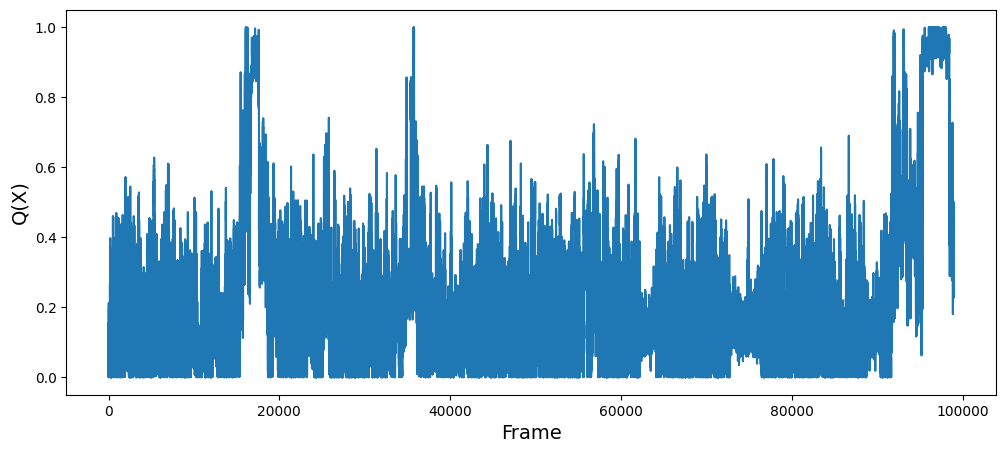

In [69]:
# Calculate Q
q = best_hummer_q(traj, native)

plt.figure(figsize=(12, 5))
plt.plot(q)
plt.xlabel('Frame', fontsize=14)
plt.ylabel('Q(X)', fontsize=14)
plt.show()

**Histogram of Q**

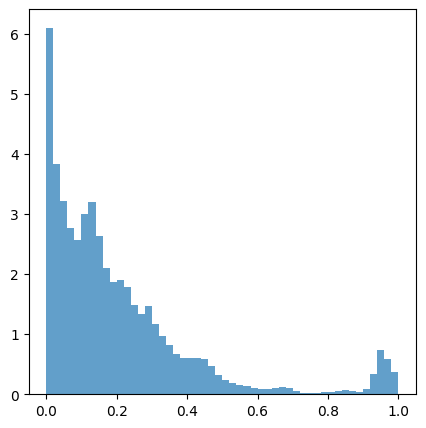

In [70]:
plt.figure(figsize=(5,5))
plt.hist(q, bins=50, alpha=0.7, histtype="stepfilled", density=True)
plt.show()

**Calculate free energy with Q**

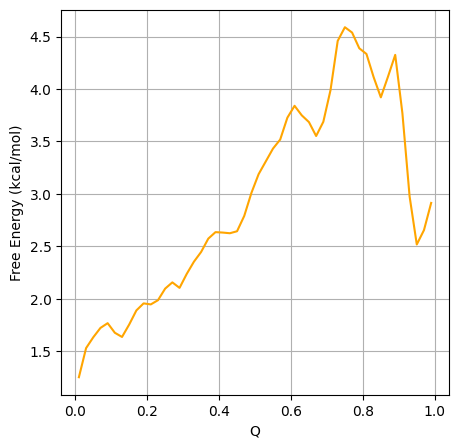

In [71]:
counts, bin_edges = np.histogram(q, bins=50)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
free_energy_values = free_energy(counts / np.sum(counts))

plt.figure(figsize=(5, 5))
plt.plot(bin_centers, free_energy_values, label='Free Energy', color='orange')
plt.xlabel('Q')
plt.ylabel('Free Energy (kcal/mol)')
plt.grid()
plt.show()

**Calculate Rg**

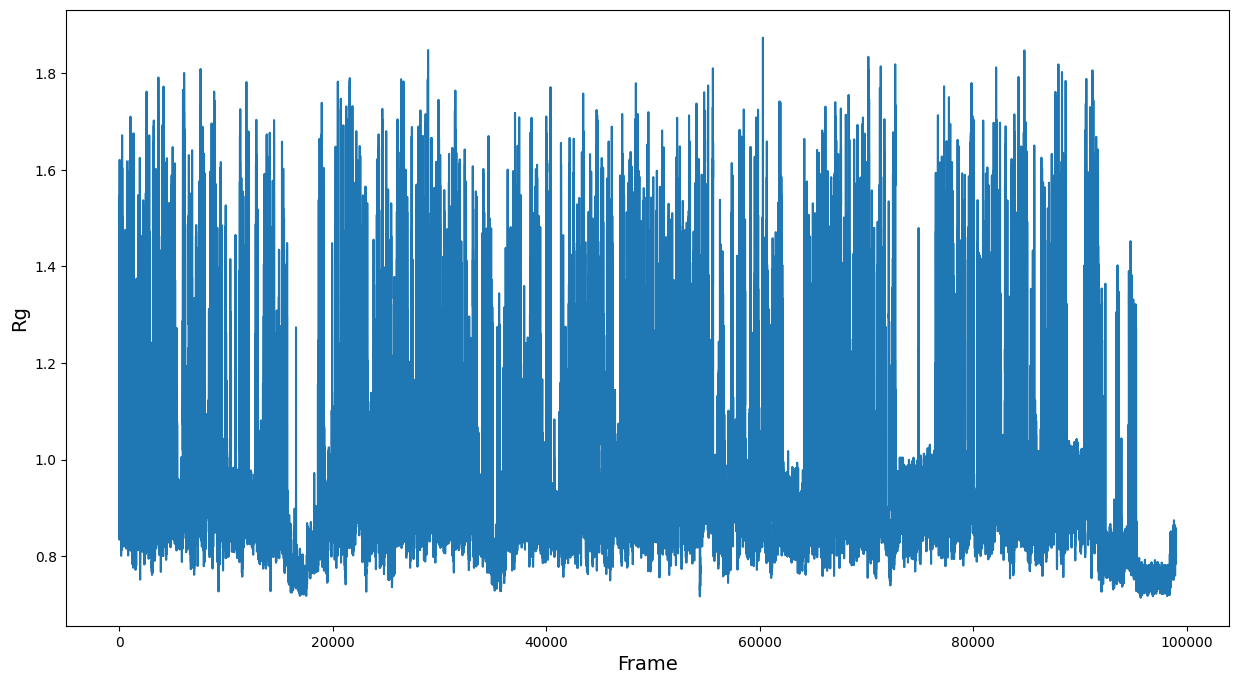

In [72]:
# Radius of gyration

rg = md.compute_rg(traj)
plt.figure(figsize=(15,8))
plt.plot(rg)
plt.xlabel('Frame', fontsize=14)
plt.ylabel('Rg', fontsize=14)
plt.show()

**Histogram of Rg**

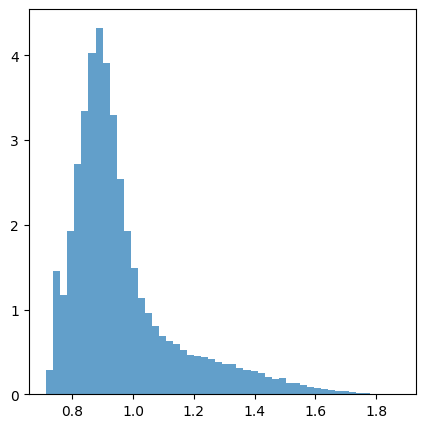

In [73]:
plt.figure(figsize=(5,5))
plt.hist(rg, bins=50, alpha=0.7, histtype="stepfilled", density=True)
plt.show()

**Calculate free energy with Rg**

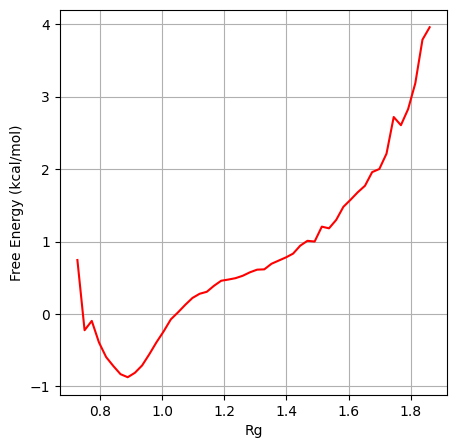

In [74]:
counts, bin_edges = np.histogram(rg, bins=50, density=True)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
free_energy_values = free_energy(counts)

plt.figure(figsize=(5, 5))
# plt.hist(rg, bins=50, alpha=0.7, histtype="stepfilled", density=True, label='Probability Density')
plt.plot(bin_centers, free_energy_values, label='Free Energy', color='red')
plt.xlabel('Rg')
plt.ylabel('Free Energy (kcal/mol)')
plt.grid()
plt.show()

**Make 2D histogram with Q and Rg**

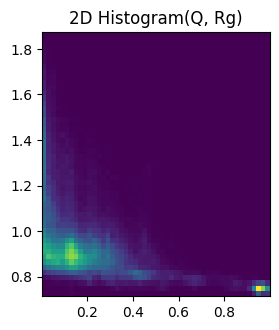

In [75]:
H, xedges, yedges = np.histogram2d(q, rg, bins=50)
H = H.T

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(132, title='2D Histogram(Q, Rg)',
        aspect='equal')
X, Y = np.meshgrid(xedges, yedges)
ax.pcolormesh(X, Y, H)

**Draw 2D free energy landscape**

### **2D Free Energy Landscape**
- Fraction of native contacts:  
- Radius of gyration  
    ```python
    import numpy as np
    import matplotlib
    matplotlib.use('Agg')
    import matplotlib.pyplot as plt

    D = <2D histogram matrix of Q, Rg>
    D = -0.5962*np.log(D)      # conversion to free energy in kcal/mol

    x = np.linspace(0, 1, nx)
    y = np.linspace(0.5, 1.5, ny)
    X, Y = np.meshgrid(x, y)

    plt.figure(figsize=(8,6))
    plt.axes(aspect='equal')
    plt.axis([0,1,0.5,1.5])
    plt.xlabel('Q')
    plt.ylabel('Radius of gyration (nm)')

    cmap = plt.get_cmap('terrain')
    CS = plt.contourf(X, Y, D, cmap=cmap, alpha=0.8, levels=[-7,-6,-5,-4,-3,-2,-1,0]) 
    plt.colorbar(CS, boundaries=[-7,-6,-5,-4,-3,-2,-1,0], label='Free energy (kcal/mol)')

    #plt.show()
    plt.savefig('output.png', transparent=True, dpi=600)
    ```

<img src="../img/free_energy_landscape.png" width=600 />

/tmp/ipykernel_932034/2518301344.py:2: RuntimeWarning: divide by zero encountered in log
  D = -0.5962*np.log(D)      # conversion to free energy in kcal/mol


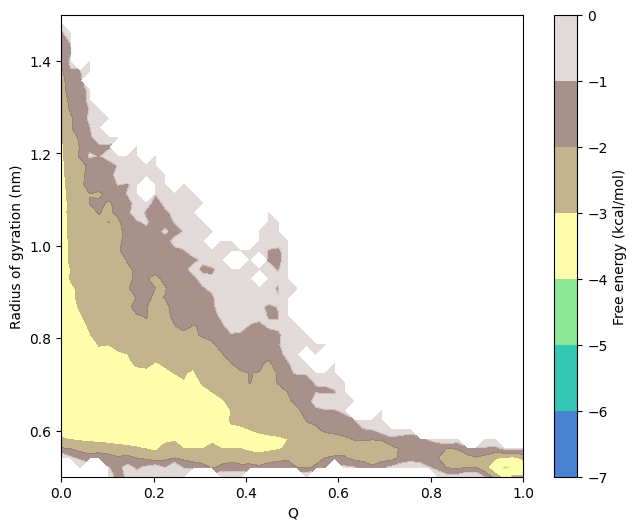

In [76]:
D = H
D = -0.5962*np.log(D)      # conversion to free energy in kcal/mol

x = np.linspace(0, 1, 50)
y = np.linspace(0.5, 1.5, 50)
X, Y = np.meshgrid(x, y)

plt.figure(figsize=(8,6))
plt.axes(aspect='equal')
plt.axis([0,1,0.5,1.5])
plt.xlabel('Q')
plt.ylabel('Radius of gyration (nm)')

cmap = plt.get_cmap('terrain')
CS = plt.contourf(X, Y, D, cmap=cmap, alpha=0.8, levels=[-7,-6,-5,-4,-3,-2,-1,0]) 
plt.colorbar(CS, boundaries=[-7,-6,-5,-4,-3,-2,-1,0], label='Free energy (kcal/mol)')

plt.show()

# plt.savefig('output.png', transparent=True, dpi=600)

### **Ramachandran Plot and DSSP**
- Phi & Psi angles determine the conformation of backbone.  
- Secondary structures have unique phi-psi angles => DSSP.  
- Ramachandran plot shows a unique pattern depending on the secondary structure.
    ```python
    import numpy as np
    import matplotlib
    matplotlib.use('Agg')
    import matplotlib.pyplot as plt

    #######################################
    # Secondary structure by DSSP
    dssp = md.compute_dssp(traj, simplified=True)
    print(dssp)
    #######################################

    # Phi & Psi angles
    phi = md.compute_phi(traj)

    print(phi)
    ```

<img src="../img/ramachandran.png" width=600 />

**Calculate visualize dssp**

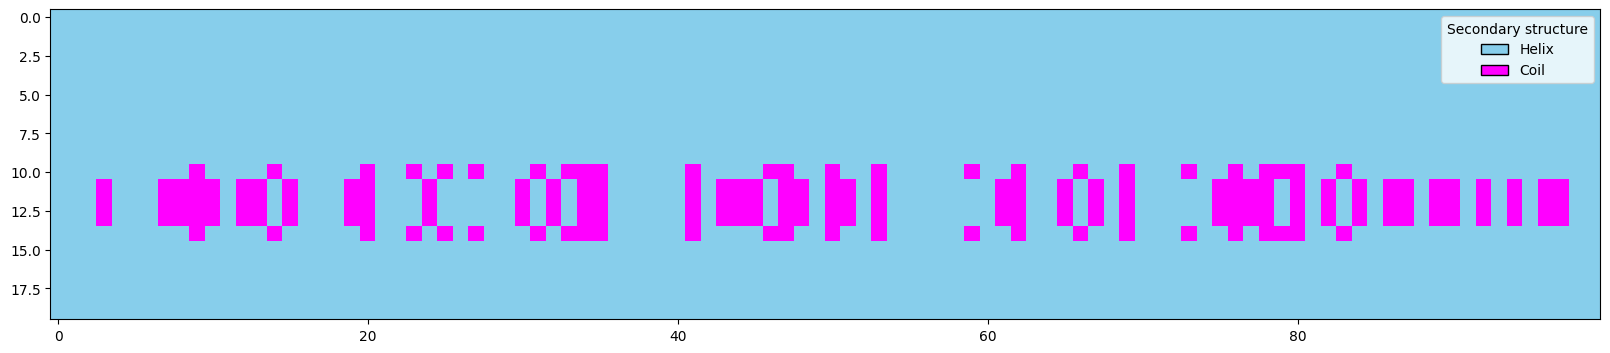

In [116]:
# Calculate dssp
dssp = md.compute_dssp(traj, simplified=True)

# Visualize
dssp_matrix = np.where(dssp == "C", 0, 1).T
plt.figure(figsize=(20, 5))
cmap = ["skyblue", "magenta"]
cmap = ListedColormap(cmap)
plt.imshow(dssp_matrix[:, 100:200], cmap=cmap)
legend_elements = [
    Patch(facecolor='skyblue', edgecolor='black', label='Helix'),
    Patch(facecolor='magenta', edgecolor='black', label='Coil')
]
plt.legend(handles=legend_elements, loc='upper right', title="Secondary structure")
plt.show()